AIM: To train MobileNetV3Large model on different parameters.

In [ ]:
# Note: Comment or delete the current code block if dataset is loaded from local disk.
# loading dataset from kaggle
# upload kaggle.json file
! pip install -q kaggle
from google.colab import files
print("Upload 'kaggle.json' file...")
files.upload()

# download the dataset(zipped folder) and unzip it
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alessiocorrado99/animals10
! unzip animals10.zip

In [ ]:
# Note: Load the class files into current working directory.
# importing required libraries
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

from keras.callbacks import ModelCheckpoint

from imutils import paths
import matplotlib.pyplot as plt
import os

import mobilenetv3l # class file
import helper_functions # class file

In [ ]:
# defining image size and batch size
batch_size=64
image_width=224
image_height=224

In [ ]:
# getting output class labels and calculating class weight
class_labels = sorted(os.listdir('raw-img')) # get class labels
print('\nClass Labels: {}'.format(class_labels))
num_classes = len(class_labels) # get number of output classes
print('\nNumber of Classes: {}'.format(num_classes))

# calculating total elements in each class
class_totals = [len(os.listdir('raw-img' + f"/{label}")) for label in class_labels]
print("\nTotal Elements in Each Class : {}".format(class_totals))

# calculate class weight
class_weight = {i:round((max(class_totals) / class_total), 3) for i, class_total in enumerate(class_totals)}
print('\nClass Weight: {}'.format(class_weight))


Class Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Number of Classes: 10

Total Elements in Each Class : [4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862]

Class Weight: {0: 1.0, 1: 1.854, 2: 3.363, 3: 2.303, 4: 1.57, 5: 2.915, 6: 2.606, 7: 2.672, 8: 1.009, 9: 2.612}


In [ ]:
# get image paths and move them into train and validation directories
imagePaths = list(paths.list_images("raw-img")) # getting path to the directory of images
print('Processing...')
helper_functions.move_images(imagePaths=imagePaths) # calling function
print('Completed...')

Processing...
Completed...


In [ ]:
# get training dataset
train_ds = image_dataset_from_directory(
  "train_dir/", label_mode='categorical', seed=42, shuffle=True,
  image_size=(image_height, image_width),
  batch_size=batch_size)

# get validation dataset
val_ds = image_dataset_from_directory(
  "valid_dir/", label_mode='categorical', seed=42, shuffle=True,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 18325 files belonging to 10 classes.
Found 7854 files belonging to 10 classes.


In [ ]:
# using buffered prefetching
shuffle_size = len(train_ds) # shuffles entire train dataset at each epoch

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# defining total epochs
epochs = 15

**Model 1:**

      INPUT => MobileNetV3Large => GAP => DO => SOFTMAX

Observations:



1.   Trainable parameters: 9,610.
2.   Best epoch: 10

  *   loss: 0.1080 - accuracy: 0.9818 - val_loss: 0.1134 - val_accuracy: 0.9716

3.   From epoch 11 onwards model starts overfitting.



12683000/12683000 [==============================] - 2s 0us/step
Model Summary...
Model: "MobileNetV3Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 10)                9610      
                                  

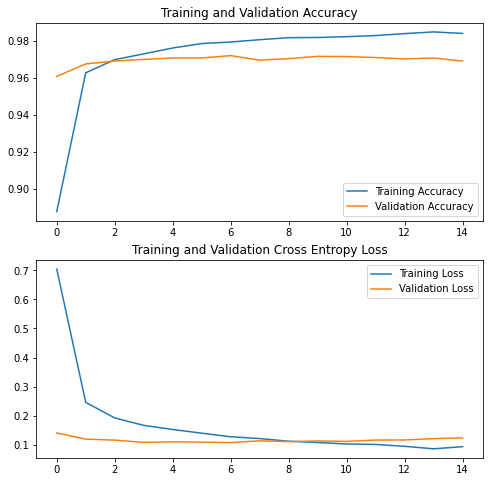

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3l.MobileNetV3L.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=False, dense_layer=False)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3L_Basic/mobilenetv3l_basic_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Model 2:**

      INPUT > MobileNetV3Large => GAP => FC => DO => SOFTMAX

Observations:


1.   Trainable parameters: 124,298.
2.   Best epoch: 4

  *   loss: 0.0939 - accuracy: 0.9842 - val_loss: 0.1100 - val_accuracy: 0.9731

3.   Quickly starts overfitting from epoch 5 onwards.

Model Summary...
Model: "MobileNetV3Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 128)               123008    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (Non

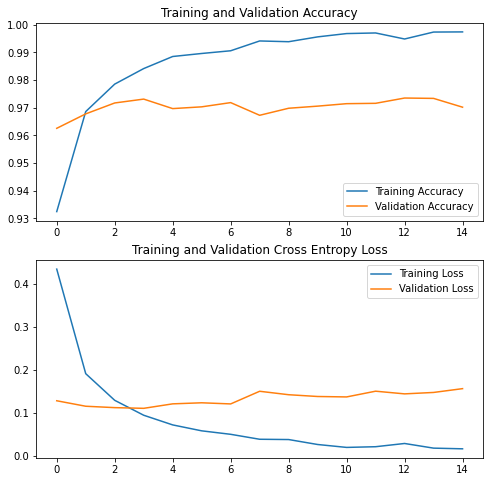

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3l.MobileNetV3L.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=False, dense_layer=True)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3L_Dense/mobilenetv3l_dense_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Model 3:**

      INPUT => AUGMENTATION => MobileNetV3Large => GAP => DO => SOFTMAX

Observations:


1.   Trainable parameters: 9,610.
2.   Validation loss is always lower than training loss.

 *   Probable Reason: Due to the use of data augmentation technique, the model might be seeing harder examples while training. 



Model Summary...
Model: "MobileNetV3Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 960)               0         
                                                                 
 dense_3 (Dense)             (Non

287/287 [==============================] - 107s 355ms/step - loss: 0.8953 - accuracy: 0.8467 - val_loss: 0.1468 - val_accuracy: 0.9570
Epoch 2/15
287/287 [==============================] - 101s 351ms/step - loss: 0.4078 - accuracy: 0.9311 - val_loss: 0.1182 - val_accuracy: 0.9672
Epoch 3/15
287/287 [==============================] - 100s 349ms/step - loss: 0.3634 - accuracy: 0.9366 - val_loss: 0.1109 - val_accuracy: 0.9694
Epoch 4/15
287/287 [==============================] - 100s 350ms/step - loss: 0.3348 - accuracy: 0.9421 - val_loss: 0.1107 - val_accuracy: 0.9693
Epoch 5/15
287/287 [==============================] - 101s 352ms/step - loss: 0.3145 - accuracy: 0.9448 - val_loss: 0.1130 - val_accuracy: 0.9688
Epoch 6/15
287/287 [==============================] - 101s 352ms/step - loss: 0.3104 - accuracy: 0.9455 - val_loss: 0.1077 - val_accuracy: 0.9701
Epoch 7/15
287/287 [==============================] - 101s 352ms/step - loss: 0.2939 - accuracy: 0.9485 - val_loss: 0.1057 - val_accura

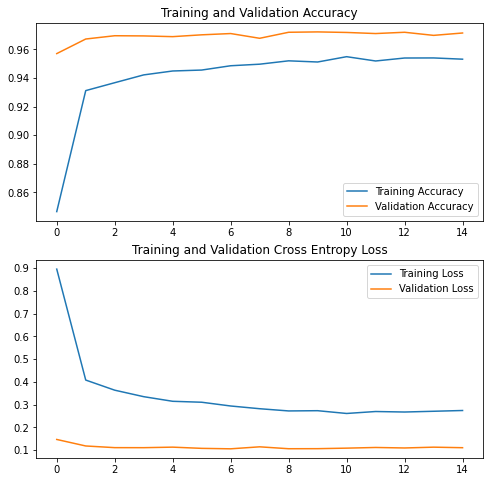

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3l.MobileNetV3L.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=True, dense_layer=False)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3L_Aug/mobilenetv3l_aug_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Conclusion:**



1.   Best epoch of Model 2 performs slightly better than best epoch of Model 1, however, trainable parameters of model 2 are approximately 12 times higher than that of Model 1.

2.   Data augmentation technique can result in lower validation loss than training loss.

